<a href="https://colab.research.google.com/github/Shen0000/MNIST-Digit-Recognition/blob/main/DigitRecognitionDML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Handwritten Digit Recognition

Add kaggle.json file to Colab before running cells

In [ ]:
!pip install kaggle
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install cupy-cuda12x

In [ ]:
!nvidia-smi

Sat May 10 19:07:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c digit-recognizer

In [ ]:
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')

In [ ]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)
# m = 42000, n = 785
# n = 785 since entry[0] stores the label for that entry and entry[1:n] stores the actual image in grayscale

data_test = data[0:8400].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255. # normalize the grayscale

data_train = data[8400:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255. # normalize the grayscale
_,m_train = X_train.shape

In [ ]:
print(m, n)

42000 785


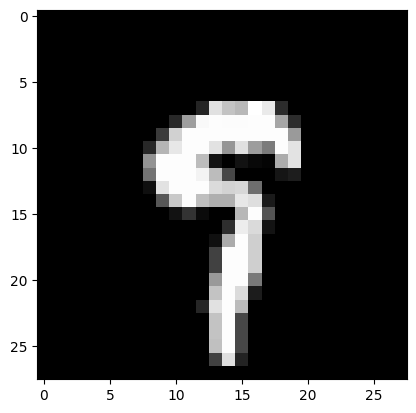

In [ ]:
current_image = X_train[:, 0, None].reshape((28, 28)) * 255
plt.gray()
plt.imshow(current_image, interpolation='nearest')
plt.show()

In [ ]:
Y_train

array([9, 8, 6, ..., 1, 0, 0])

In [ ]:
X_train[:, 0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
layer_dims = [784, 128, 64, 10]  # input, hidden1, hidden2, output

In [ ]:
def init_params():
    # He initilization
    W1 = cp.random.randn(128, 784) * cp.sqrt(2. / 784)
    b1 = cp.zeros((128, 1))

    W2 = cp.random.randn(64, 128) * cp.sqrt(2. / 128)
    b2 = cp.zeros((64, 1))

    W3 = cp.random.randn(10, 64) * cp.sqrt(2. / 64)
    b3 = cp.zeros((10, 1))
    return W1, b1, W2, b2, W3, b3

def compute_loss(A3, Y):
    m = Y.shape[0]
    return -cp.sum(Y * cp.log(A3)) / m

def ReLU(Z):
    return cp.maximum(Z, 0)

def softmax(Z):
    A = cp.exp(Z) / sum(cp.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = cp.zeros((Y.size, int(Y.max() + 1)))
    one_hot_Y[cp.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * cp.sum(dZ3)
    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * cp.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * cp.sum(dZ1)
    return dW1, db1, dW2, db2, dW3, db3

def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3

In [ ]:
def get_predictions(A3):
    return cp.argmax(A3, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3  = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A3)
            print(get_accuracy(predictions, Y))
            print(f"Loss: {compute_loss(A3, Y)}")
    return W1, b1, W2, b2, W3, b3

In [ ]:
W1, b1, W2, b2, W3, b3 = gradient_descent(cp.asarray(X_train), cp.asarray(Y_train), 0.25, 1000)

Iteration:  0
[6 6 2 ... 6 6 2] [9 8 6 ... 1 0 0]
0.08407738095238096
Loss: 105.73108416035926
Iteration:  10
[5 8 6 ... 1 0 0] [9 8 6 ... 1 0 0]
0.6640178571428571
Loss: 153.21416748307234
Iteration:  20
[9 8 6 ... 1 0 0] [9 8 6 ... 1 0 0]
0.7058333333333333
Loss: 189.07369486007948
Iteration:  30
[9 8 6 ... 1 0 0] [9 8 6 ... 1 0 0]
0.805
Loss: 224.32700003750588
Iteration:  40
[9 8 6 ... 1 0 0] [9 8 6 ... 1 0 0]
0.8655952380952381
Loss: 244.47330072598794
Iteration:  50
[9 8 6 ... 1 0 0] [9 8 6 ... 1 0 0]
0.8922619047619048
Loss: 253.55182266791508
Iteration:  60
[9 8 6 ... 1 0 0] [9 8 6 ... 1 0 0]
0.8954761904761904
Loss: 272.3244777922957
Iteration:  70
[9 8 6 ... 1 0 0] [9 8 6 ... 1 0 0]
0.899375
Loss: 278.6523030500479
Iteration:  80
[9 8 6 ... 1 0 0] [9 8 6 ... 1 0 0]
0.910625
Loss: 288.82824678635865
Iteration:  90
[9 8 6 ... 1 0 0] [9 8 6 ... 1 0 0]
0.9155654761904762
Loss: 296.919075418723
Iteration:  100
[9 8 6 ... 1 0 0] [9 8 6 ... 1 0 0]
0.9183333333333333
Loss: 302.766823

Check model on Testing Dataset

In [ ]:
data_test = pd.read_csv('test.csv')

In [ ]:
def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = cp.asarray(X_train[:, index, None])
    prediction = make_predictions(cp.asarray(X_train[:, index, None]), W1, b1, W2, b2, W3, b3)
    label = cp.asarray(Y_train[index])
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = cp.asnumpy(current_image.reshape((28, 28))) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [9]
Label:  9


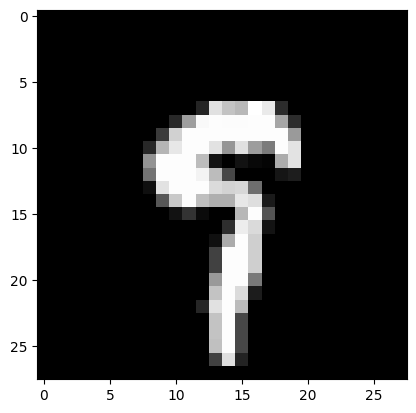

Prediction:  [8]
Label:  8


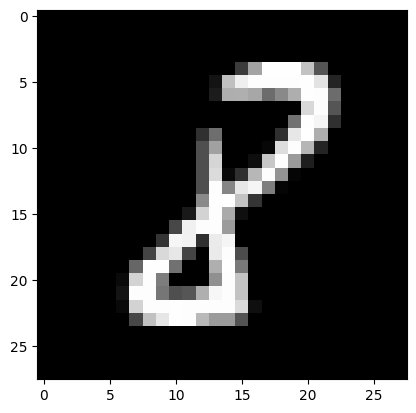

Prediction:  [6]
Label:  6


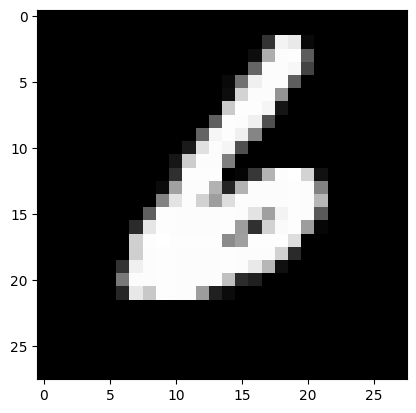

Prediction:  [9]
Label:  9


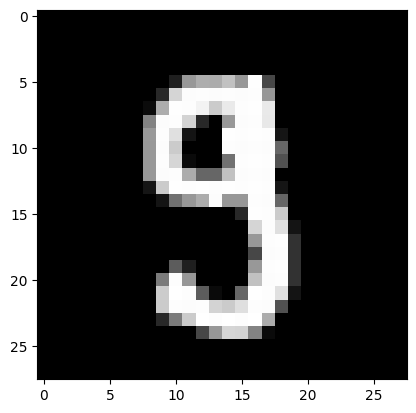

In [ ]:
test_prediction(0, W1, b1, W2, b2, W3, b3)
test_prediction(1, W1, b1, W2, b2, W3, b3)
test_prediction(2, W1, b1, W2, b2, W3, b3)
test_prediction(3, W1, b1, W2, b2, W3, b3)

In [ ]:
dev_predictions = make_predictions(cp.asarray(X_test), W1, b1, W2, b2, W3, b3)
get_accuracy(dev_predictions, cp.asarray(Y_test))

[9 4 9 ... 2 0 8] [9 4 9 ... 8 0 8]


array(0.9627381)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(W1.shape)
print(b1.shape)
print(W2.shape)
print(b2.shape)
print(W3.shape)
print(b3.shape)

(784, 33600)
(33600,)
(128, 784)
(128, 1)
(64, 128)
(64, 1)
(10, 64)
(10, 1)


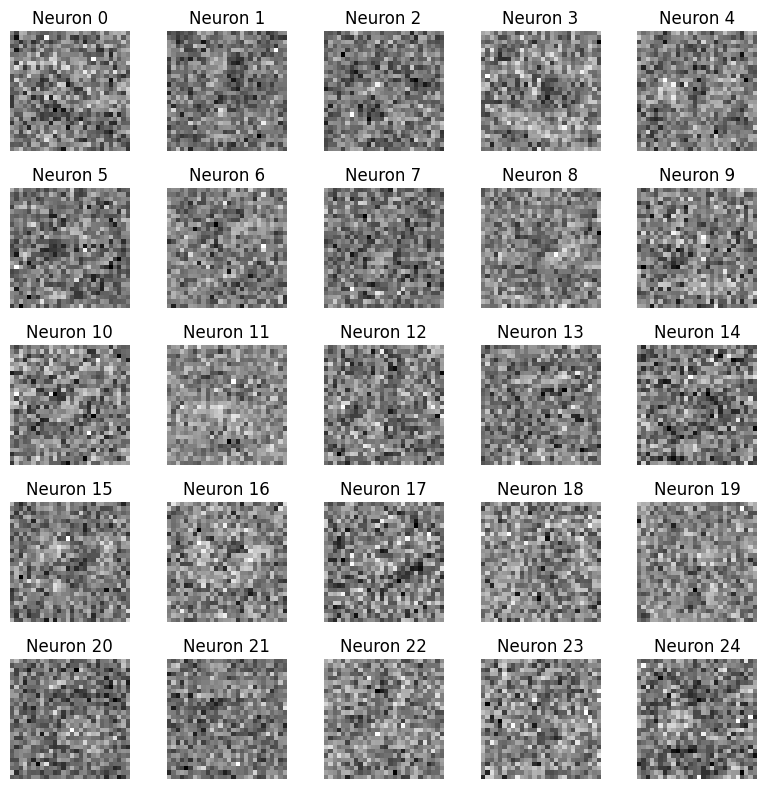

In [ ]:
# Assume W1 is already defined and has shape (128, 784)
# We'll visualize the first 16 neurons' weights
num_features = 25
fig, axes = plt.subplots(5, 5, figsize=(8, 8))

W1 = cp.asnumpy(W1)

for i, ax in enumerate(axes.flat):
    if i < num_features:
        # Reshape the i-th neuron's weights to 28x28
        weight_image = W1[i].reshape(28, 28)

        ax.imshow(weight_image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Neuron {i}")

plt.tight_layout()
plt.show()